# What makes a good wikiHow article? 
In this project, we attempt to determine which of the features (e.g. title, related article, views, authors) in a wikiHow article mostly influence its quality, measured by helpfulness.

In [ ]:
import os
import random
random.seed(29)
import json
import csv
!pip install afinn
import pandas as pd
from afinn import Afinn
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab 
import numpy as np    
import re
import string
import seaborn as sn

     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp36-none-any.whl size=53450 sha256=66685ccdcd9fe035360c0fb7495fe23a99f1aca75f2e23c573a1a44d13d1d0cf
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


## Data Preparation
We will be using the wikiHow corpus ([Zhang et al., 2020](https://www.aclweb.org/anthology/2020.emnlp-main.374/)).

In [ ]:
!gdown --id 1ePtm5eHl2F_YvPJX_jD8DD0x2NwQ-FUp
!unzip -q js_files_en.zip

Downloading...
From: https://drive.google.com/uc?id=1ePtm5eHl2F_YvPJX_jD8DD0x2NwQ-FUp
To: /content/js_files_en.zip
531MB [00:04, 130MB/s]


We first randomly split the json files into 80-10-10 training-validation-testing splits. 

In [ ]:
json_list = os.listdir('./js_files_en')
random.shuffle(json_list)
json_train = json_list[:int(len(json_list)*.8)]
json_valid = json_list[int(len(json_list)*.8):int(len(json_list)*.9)]
json_test = json_list[int(len(json_list)*.9):]

Here, we read in the json files in each split. There are a lot of features for each article so we've decided to simplify our task by only considering a few of them: title, coauthors, views, steps, and related articles. The 'steps' feature is simply the number of points in the step-by-step process outlined by the Wikihow article. As stated before, the label is the percentage of "helpful" votes. While the task can naturally be formatted as regression, we will treat it as text classification instead. To do so, we bin the percentage of "helpful" votes into 4 buckets: [0,25), [25,50), [50,75), [75,100], represented as 0 thru 3 respectively. 

In [ ]:
splits = ['train', 'valid', 'test']
titles_train = []
titles_valid = []
titles_test = []
helpful_train = []
helpful_valid = []
helpful_test = []
n_coauthors_train = []
n_coauthors_test = []
n_coauthors_valid = []
n_views_train = []
n_views_test = []
n_views_valid = []
n_steps_train = []
n_steps_test = []
n_steps_valid = []
n_related_articles_train = []
n_related_articles_test = []
n_related_articles_valid = []

for split in splits:
  for fname in eval(f'json_{split}'):
    with open(os.path.join('js_files_en', fname)) as f:
      jobj = json.load(f)
      title = jobj['title']

      if jobj["author"]["n_coauthors"] != None:
        n_coauthors = jobj["author"]["n_coauthors"]
      else:
        n_coauthors = 0

      if jobj["n_views"] != None:
        n_views = jobj["n_views"]
      else:
        n_views = 0    
      n_steps = sum([len(method) for method in jobj['methods']])
      n_related_articles = len(jobj['related_articles'])
      helpful_percent = jobj['rating']['helpful_percent']

      if title is None or helpful_percent is None:
        continue
      if helpful_percent < 25:
        helpful = 0
      elif helpful_percent < 50:
        helpful = 1
      elif helpful_percent < 75:
        helpful = 2
      else:
        helpful = 3

      eval(f'titles_{split}').append(title)
      eval(f'helpful_{split}').append(helpful)
      eval(f'n_coauthors_{split}').append(n_coauthors)
      eval(f'n_steps_{split}').append(n_steps)
      eval(f'n_views_{split}').append(n_views)
      eval(f'n_related_articles_{split}').append(n_related_articles)

## Exploratory data analysis

Let's explore our data! First, we should build dataframes which consists of data of the features that we are interested in.

In [ ]:
train_list = {'title': titles_train, 'n_coauthors': n_coauthors_train, 'n_views': n_views_train, 'n_steps': n_steps_train, 'n_related_articles': n_related_articles_train, 'helpful': helpful_train}
test_list = {'title': titles_test, 'n_coauthors': n_coauthors_test, 'n_views': n_views_test, 'n_steps': n_steps_test, 'n_related_articles': n_related_articles_test, 'helpful': helpful_test}
val_list = {'title': titles_valid, 'n_coauthors': n_coauthors_valid, 'n_views': n_views_valid, 'n_steps': n_steps_valid, 'n_related_articles': n_related_articles_valid, 'helpful': helpful_valid}


train_df = pd.DataFrame(train_list)
test_df = pd.DataFrame(test_list)
val_df = pd.DataFrame(val_list)

train_df.head()


,title,n_coauthors,n_views,n_steps,n_related_articles,helpful
0,How to Meditate With a Crystal,4,26233,0,14,3
1,How to Make a Kusudama Flower,70,928139,0,14,3
2,How to Make an Advertising Flyer,25,54205,12,10,2
3,How to Protect Windows from Hurricanes,2,7025,6,14,2
4,How to Eat Healthily at a Mexican Restaurant,18,21923,12,12,3


Upon examination of the training data, we can see that most of our articles fall are scored as 3 for helpfulness. This is to be expected, as our range of helpfulness is 0-3, and the articles will likely be skewed towards the higher end of this range. There don't seem to be any exteme outliers (barring the max for number of coauthors), so the data looks relatively clean so far.

In [ ]:
train_df.describe()

,n_coauthors,n_views,n_steps,n_related_articles,helpful
count,69667.000000,6.966700e+04,69667.000000,69667.000000,69667.000000
mean,18.640691,1.836386e+05,7.258071,12.068813,2.598476
std,28.696456,5.778620e+05,6.092856,3.393355,0.682124
min,0.000000,4.100000e+01,0.000000,0.000000,0.000000
25%,6.000000,1.186300e+04,4.000000,12.000000,2.000000
50%,11.000000,4.073200e+04,6.000000,14.000000,3.000000
75%,20.000000,1.452605e+05,12.000000,14.000000,3.000000
max,934.000000,2.977419e+07,84.000000,54.000000,3.000000


Let's look at the distribution of each numerical feature.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54053 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48729 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

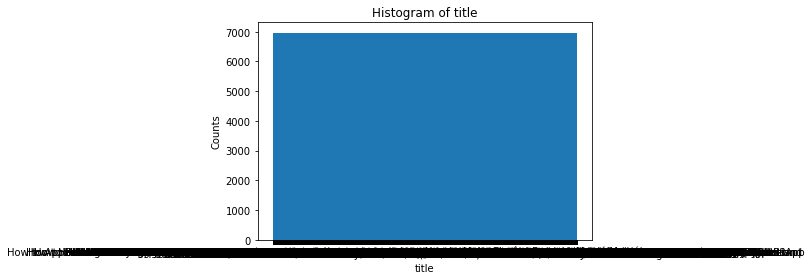

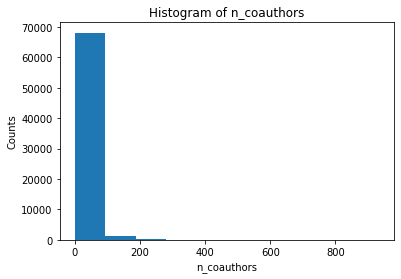

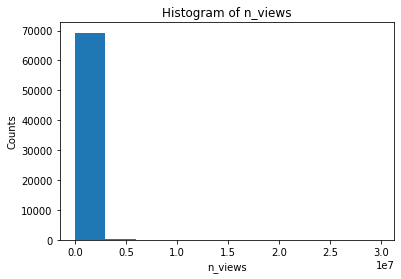

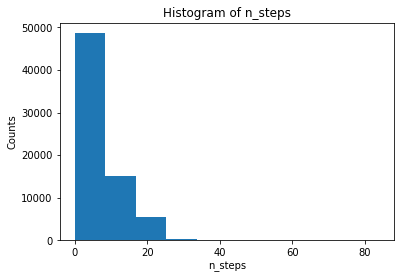

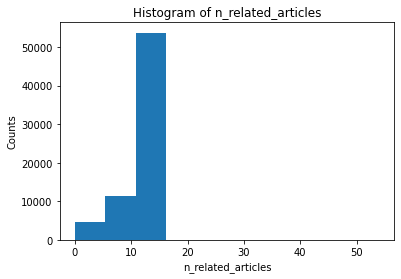

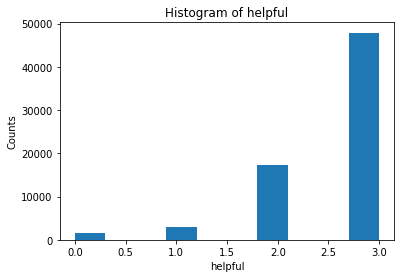

In [ ]:

# the histogram of the helpfulness
for (columnName, columnData) in train_df[2:].iteritems(): 
    plt.hist(columnData)
    plt.xlabel(columnName)
    plt.ylabel('Counts')
    plt.title('Histogram of ' + columnName)

    plt.show()


The histograms don't explain much, beyond just letting us know that the numerical features aren't distributed symmetrically. This doesn't give us much additional information, unless we were using regression, in which case we might try to normalize the features before using them in regression. Let's get a preliminary look at how our features are related by examining a correlation matrix.

                    n_coauthors   n_views  ...  n_related_articles   helpful
n_coauthors            1.000000  0.631951  ...           -0.000977  0.015263
n_views                0.631951  1.000000  ...            0.013771  0.042513
n_steps                0.138233  0.112707  ...            0.042951  0.078663
n_related_articles    -0.000977  0.013771  ...            1.000000  0.026634
helpful                0.015263  0.042513  ...            0.026634  1.000000

[5 rows x 5 columns]


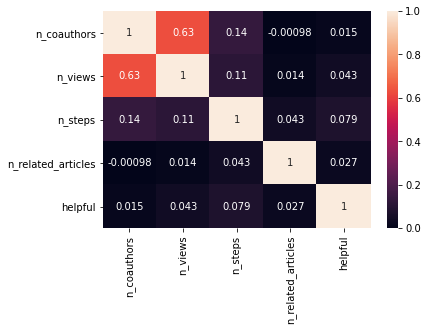

In [ ]:
corrMatrix = train_df.corr()
print (corrMatrix)
sn.heatmap(corrMatrix, annot=True)
plt.show()

Looking at the heatmap (just a visually easier representation of the printed correlation matrix), we can see there is a strong correlation between the number of views an article has, and the number of coauthors it has. Perhaps this is due to 'by author' searches - articles with more authors will get listed more if people search for articles by authors.

More importantly, we see the the number of steps is the most correlated to our label, with a 8% correlation. This, of course, makes intuitive sense - we will see whether this feature appears in our models below. 

Now, we will clean our data by removing uninformative (too common) words from the title of our articles. The first step is to make everything lowercase.

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('ieer')
nltk.download('stopwords')

train_df['title'] = train_df['title'].apply(lambda x: x.lower())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package ieer to /root/nltk_data...
[nltk_data]   Package ieer is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, we use SpaCy for the removal of stopwords and lemmatization

In [ ]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
train_df['lemmatized']=train_df['title'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
test_df['lemmatized']=train_df['title'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

Below is an example of the kinds of changes our cleaning has made. You can see that there are no stopwords in the lemmatized version, and everything is lowercase.

In [ ]:
print(train_df['title'].head())
print(train_df['lemmatized'].head())

0                  how to meditate with a crystal
1                   how to make a kusudama flower
2                how to make an advertising flyer
3          how to protect windows from hurricanes
4    how to eat healthily at a mexican restaurant
Name: title, dtype: object
0                    meditate crystal
1                     kusudama flower
2                   advertising flyer
3            protect window hurricane
4    eat healthily mexican restaurant
Name: lemmatized, dtype: object


Below, we create a document term matrix. This is essentially a reorganization of our titles, so we can examine the qualities of each individual word. In the document term matrix, we can see how many times a particular word appeared in a 0-score helpful article, in a 1-score helpful article, etc.. 

In [ ]:
# Group the entries by helpful scores
df_grouped=train_df[['helpful','lemmatized']].groupby(by='helpful').agg(lambda x:' '.join(x))
df_grouped.head()

# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')

data=cv.fit_transform(df_grouped['lemmatized'])
dtm_df = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
dtm_df.index=df_grouped.index
dtm_df.head(4)

,00,000,007,01,06,07,09,0l,10,100,1000,10000,100th,1040,1040ez,1040x,106,1099,10f,10k,11,110,117,11th,12,120,1217,125,12v,13,130,13th,14,14er,14th,15,150,1500,16,1650,...,zion,zip,zipcar,ziplock,zipper,zippered,zippo,zirconia,zit,ziti,zobo,zodiac,zoetrope,zoey,zoho,zoidberg,zola,zoloft,zombie,zone,zongzi,zoning,zoo,zoodle,zooey,zookeeper,zoologist,zoom,zoosk,zorro,zoster,zpass,ztr,zucchini,zumba,zune,zydeco,éclair,ălăk,팥빙수
helpful,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,1,2,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,0,0,1,0,0,0,0,0,2,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,0,1,1,1,1,2,18,7,2,0,1,1,0,1,1,0,1,0,1,0,0,0,6,0,1,1,0,5,1,1,3,0,1,0,1,0,4,0,...,0,0,1,0,9,1,2,0,0,0,0,1,0,0,0,1,0,0,14,7,1,2,4,1,0,0,0,1,1,0,0,0,0,3,0,0,1,0,1,1
3,1,2,1,0,0,0,0,2,28,17,2,1,1,0,1,0,0,3,0,1,4,0,1,0,10,0,0,0,1,4,0,2,2,1,0,9,4,1,2,1,...,1,2,1,1,8,0,3,3,2,1,1,0,1,2,1,0,0,2,11,5,0,1,8,2,1,1,1,0,0,1,1,1,1,29,1,1,0,1,0,0


To further visualize importance of individual words in the title, we look at a wordcloud, for each helpfulness score.
 

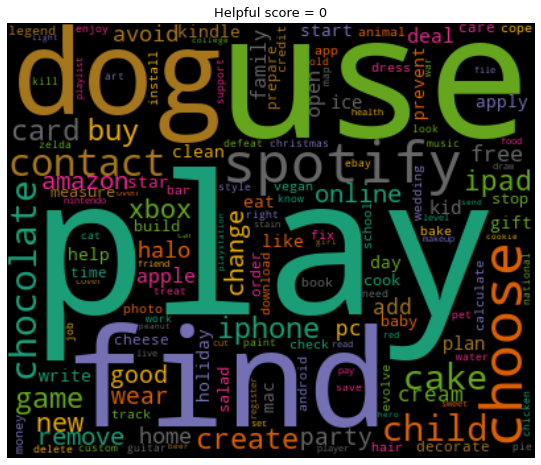

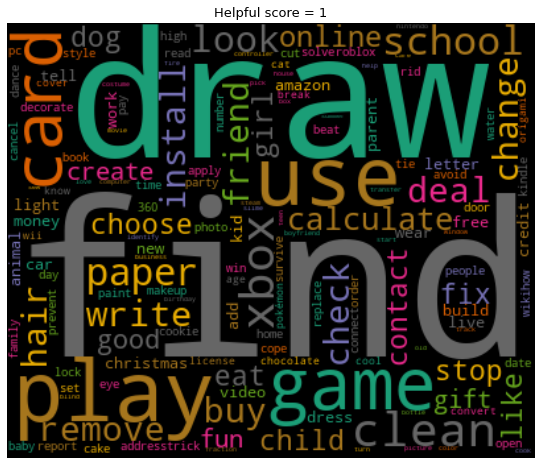

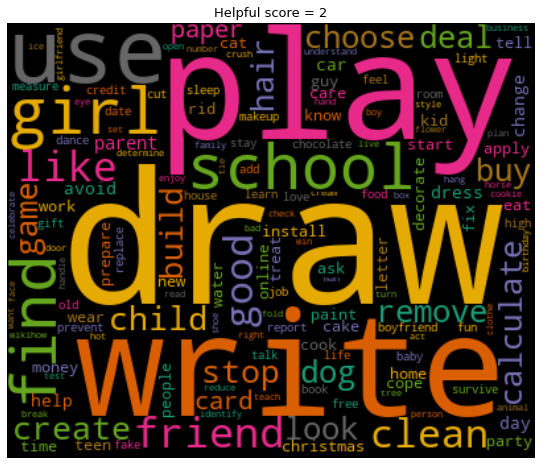

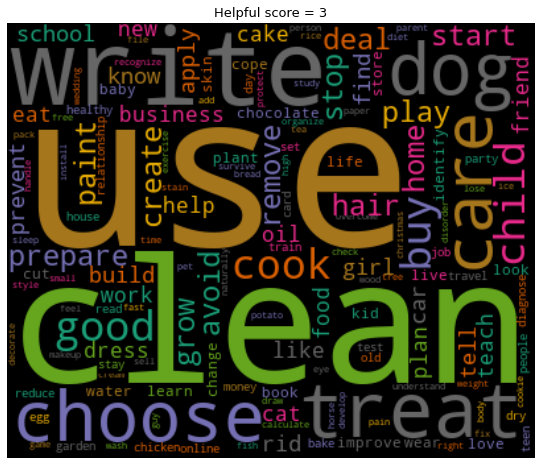

In [ ]:
from wordcloud import WordCloud
from textwrap import wrap

def gen_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('Helpful score = ' + str(title),fontsize=13)
  plt.show()
  

dtm_T_df=dtm_df.transpose()
for i, helpful in enumerate(dtm_T_df.columns):
  gen_wordcloud(dtm_T_df[helpful].sort_values(ascending=False),helpful)

Below we conduct some sentiment analysis to obtain another feature for our models. In particular, we create a feature called "polarity", which is a measure of how extreme (positive vs negative) a lemmatized title is. We use the 'textblob' library for this calculation. To illustrate the nature of this feature, we print out the 10 titles with highest/lowest polarity.


In [ ]:
from textblob import TextBlob
train_df['polarity']=train_df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [ ]:
print("10 Random titles with Highest Polarity:")
for index,title in enumerate(train_df.iloc[train_df['polarity'].sort_values(ascending=False)[:10].index]['title']):
  print('Title {}:\n'.format(index+1),title)

print("\n 10 Random titles with Lowest Polarity:")
for index,title in enumerate(train_df.iloc[train_df['polarity'].sort_values(ascending=True)[:10].index]['title']):
  print('Title {}:\n'.format(index+1),title)

10 Random titles with Highest Polarity:
Title 1:
 how to be awesome in your class
Title 2:
 how to be girly and flawless
Title 3:
 how to find the perfect topic for an informal speech
Title 4:
 how to be the perfect guest
Title 5:
 how to find excellent day care
Title 6:
 how to choose the perfect wedding cake and wedding cake topper
Title 7:
 how to be awesome
Title 8:
 how to determine the perfect shampoo and conditioner
Title 9:
 how to get perfect pitch
Title 10:
 how to make the perfect doritos ad

 10 Random titles with Lowest Polarity:
Title 1:
 how to deal with nasty people
Title 2:
 how to get the infinite rocket launcher in resident evil 5
Title 3:
 how to deal with an evil ex boyfriend
Title 4:
 how to get through a boring performance while sitting in the audience
Title 5:
 how to act evil
Title 6:
 how to kill yawn in resident evil
Title 7:
 how to get out of a boring conversation
Title 8:
 how to spice up a boring bedroom
Title 9:
 how to avoid holding a boring work christ

## Baseline Modeling 
Next, we will attempt a series of machine learning models. First, we will try ML models using numerical features, and then we will use NLP method for titles as feature. First, we define a helper function to print nice confusion matrices. This will prove helpful in identifying where our models are messing up.


In [ ]:
from sklearn.metrics import confusion_matrix

# A helper function which prints  nicer confusion matrices
def plot_confusion_matrix(correct_labels, predict_labels, labels, display_labels, title='Confusion matrix', tensor_name = 'MyFigure/image', normalize=False):
  ''' 
  Parameters:
      correct_labels                  : These are your true classification categories.
      predict_labels                  : These are you predicted classification categories
      labels                          : This is a lit of labels which will be used to display the axix labels
      title='Confusion matrix'        : Title for your matrix
      tensor_name = 'MyFigure/image'  : Name for the output summay tensor

  Returns:
      summary: TensorFlow summary 

  Other itema to note:
      - Depending on the number of category and the data , you may have to modify the figzie, font sizes etc. 
      - Currently, some of the ticks dont line up due to rotations.
  '''
  cm = confusion_matrix(correct_labels, predict_labels, labels=labels)
  if normalize:
      cm = cm.astype('float')*10 / cm.sum(axis=1)[:, np.newaxis]
      cm = np.nan_to_num(cm, copy=True)
      cm = cm.astype('int')

  np.set_printoptions(precision=2)
  ###fig, ax = matplotlib.figure.Figure()

  fig = matplotlib.pyplot.figure(figsize=(2, 2), dpi=320, facecolor='w', edgecolor='k')
  ax = fig.add_subplot(1, 1, 1)
  im = ax.imshow(cm, cmap='Oranges')

  classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in display_labels]
  classes = ['\n'.join(wrap(l, 40)) for l in classes]

  tick_marks = np.arange(len(classes))

  ax.set_xlabel('Predicted', fontsize=7)
  ax.set_xticks(tick_marks)
  c = ax.set_xticklabels(classes, fontsize=4, rotation=-90,  ha='center')
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  ax.set_ylabel('True Label', fontsize=7)
  ax.set_yticks(tick_marks)
  ax.set_yticklabels(classes, fontsize=4, va ='center')
  ax.yaxis.set_label_position('left')
  ax.yaxis.tick_left()

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      ax.text(j, i, format(cm[i, j], 'd') if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color= "black")
  fig.set_tight_layout(True)
  matplotlib.pyplot.show()

  return

In [ ]:
from sklearn.neural_network import MLPClassifier

feature_cols = ['n_coauthors', 'n_views', 'n_steps', 'n_related_articles']

mlp_x_train = train_df.loc[:, feature_cols]
mlp_y_train = train_df.helpful
mlp_x_test = test_df.loc[:, feature_cols]
mlp_y_test = test_df.helpful
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 200, 20), random_state=1)

mlp.fit(mlp_x_train, mlp_y_train)

y_pred_MLP = mlp.predict(mlp_x_test)

print("MLP accuracy: ", mlp.score(mlp_x_test, mlp_y_test))

MLP accuracy:  0.02399636074149892


As we can see, the MLP (multi-layer perceptron, aka, neural network) model on numerical features doesn't tell us anything, which suggests that we need to take a look at other kinds of features, i.e., the title. With an accuracy of only 2%, it isn't even worth trying to improve this MLP model via the confusion matrix.

Our next model will thus come from NLP. Before doing anything, we use LASSO to determine which title words are most useful in determining helpfulness of an article. To do so, we one hot encode the words in the titles, and each title is simple a vector of 1's and 0's, which 1's in spots corresponding to words the title contains. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
import itertools
from collections import Counter


lemmatized_titles = [title.split(' ') for title in train_df['lemmatized']]

all_tokens = itertools.chain.from_iterable(lemmatized_titles)
token_counter = Counter(all_tokens)
k = 5000
top_k_freq_tokens = [key for key, val in token_counter.most_common(k)]
word_to_id = {token: idx for idx, token in enumerate(set(top_k_freq_tokens))}
id_to_word = {v: k for k, v in word_to_id.items()}

def get_vec(token_id_list):
  vec = np.zeros(len(top_k_freq_tokens) + 1)
  for token_id in token_id_list:
    vec[token_id] = 1
  return vec

# convert token lists to one-hot-encoded version
one_hot_encoded_titles = [get_vec([word_to_id.get(token, -1) for token in tokens_doc]) for tokens_doc in lemmatized_titles]

# use alpha < .01 to get nonzero terms
clf = linear_model.Lasso(alpha=.002)
clf.fit(one_hot_encoded_titles, train_df['helpful'])

selected_words = set()
for token_id, coeff in enumerate(clf.coef_):
  if coeff != 0 and token_id < len(id_to_word):
    selected_words.add((id_to_word[token_id], coeff))

print(sorted(selected_words, key = lambda x: -x[1]))

[('treat', 0.09535601774796201), ('grow', 0.05918162893890491), ('clean', 0.05063232976002521), ('care', 0.015588743823750209), ('card', -0.029406566792426675), ('game', -0.04769529536427812), ('play', -0.11297427311700711), ('find', -0.13090669494576665), ('draw', -0.3563194552833141)]


The words selected by LASSO above are the words that had enough explanatory power to be worth the penalty they recieved in LASSO penalty function. The coefficients on these words tell us whether they contribute to helpfulness or detract from it. For example, 'treat' has a coefficient of .09, meaning articles with 'helpful' in the title are generally very helpful, and 'draw' has a coefficient of -.356 meaning the exact opposite.

Next, we create a bag-of-words model for our titles and then proceed to run Naive Bayes, Logistic Regression and Random Forest on top of our features.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 
max_features = 1500

count_vectorizer = CountVectorizer(max_features=max_features,stop_words = "english")

train_sparce_matrix = count_vectorizer.fit_transform(train_df['lemmatized']).toarray()
test_sparce_matrix = count_vectorizer.fit_transform(test_df['lemmatized']).toarray()

words=count_vectorizer.get_feature_names()
print("Most used words: ",words[50:100])

Most used words:  ['attack', 'attend', 'attention', 'attorney', 'attract', 'attractive', 'australia', 'autistic', 'avoid', 'away', 'baby', 'backpack', 'bacon', 'bad', 'bag', 'bake', 'baked', 'balance', 'ball', 'ballet', 'balloon', 'banana', 'band', 'bank', 'bankruptcy', 'bar', 'barbecue', 'barbie', 'base', 'baseball', 'basic', 'bath', 'bathe', 'bathroom', 'battery', 'battle', 'battlefield', 'beach', 'bean', 'bear', 'beat', 'beauty', 'bed', 'bedroom', 'bee', 'beef', 'beer', 'beginner', 'behavior', 'bend']


### Naive Bayes Model

Below, we train a Gaussian Naive Bayes on just the vectorized titles. Note that our previous MLP model was training on 4 out of our 5 features, and this model is trained on only 1 out of our 5 features. We will see that even so, this NB model hugely outperforms the MLP model.

The algorithm to train this model comes from here:
http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf

In [ ]:
from textwrap import wrap
import re
import itertools

In [ ]:
y_train = helpful_train
y_test = helpful_test
x_train = train_sparce_matrix
x_test = test_sparce_matrix

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train)
y_pred_NB = nb.predict(x_test)

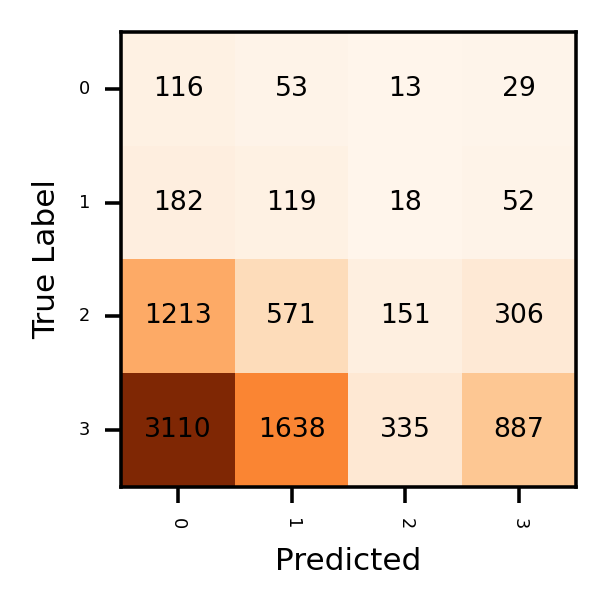

Naive Bayes accuracy:  0.33845104060047765


In [ ]:
labels = [0,1,2,3]
display_labels = ['0','1','2','3']
plot_confusion_matrix(y_test, y_pred_NB, labels, display_labels, title="Confusion matrix")
print("Naive Bayes accuracy: ",nb.score(y_pred_NB.reshape(-1,1),y_test))

We can see that the Naive Bayes model on titles give a huge improvement than the model on numerical features. The accuracy is 33%., up from 2% in the MLP model and the confusion matrix shows a (somewhat) even distribution of mistakes. The problem with this model is that it predicts 0 too much, when the true label is 3. This error is expected, however, due to the massive number of 3-scored articles, as we saw in our EDA.

### Logistic regression

Now, we try a logistic regression, again only using the bag-of-words converted titles as our features. This seems to be more informative so we continue the trend. To limit runtime, we limit the number of iterations to 500, which should be more than enough. 

In [ ]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(max_iter=500)
lr.fit(x_train,y_train)
print("Logistic regression accuracy: ",lr.score(x_test,y_test))


Logistic regression accuracy:  0.6435801205504379


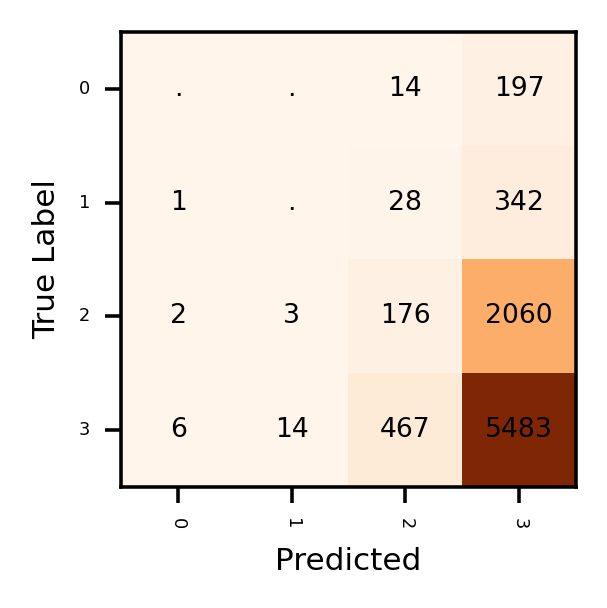

In [ ]:
y_pred_LR = lr.predict(x_test)
plot_confusion_matrix(y_test, y_pred_LR, labels, display_labels, title="Confusion matrix")

The logistic regression doubles the performance of Naive Bayes, which gives a more satisfying result.

### Random forest

Finally, in the last part of this section, we shall try Random forest model which is the most complicated model among this section.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 300, criterion = "entropy", random_state = 0)
rf.fit(x_train, y_train)
print("Random forest accuracy: ", rf.score(x_test,y_test))

Random forest accuracy:  0.5943364039576936


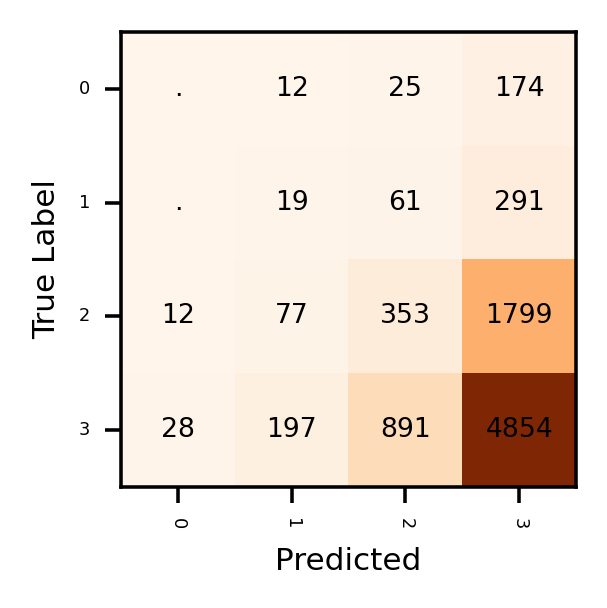

In [ ]:
y_pred_RF = rf.predict(x_test)
plot_confusion_matrix(y_test, y_pred_RF, labels, display_labels, title="Confusion matrix")

Though it takes a much longer time to train, the performance is acutually slightly worse than Logistic Regression. Generally, logistic regression performs better on datasets with low dimensionality, so this result came as a suprise to us, since our bag of words model introduces a lot of dimensions to our problem. Perhaps we can atttribute the slight dip in accuracy to the type of noise in our data, which has been known factor into the efficacy of logistic regression vs random forests (https://scholar.smu.edu/cgi/viewcontent.cgi?article=1041&context=datasciencereview#:~:text=In%20general%2C%20logistic%20regression%20performs,variables%20increases%20in%20a%20dataset).

# State-of-the-art NLP model
Here, we use a state-of-the-art NLP model to do the task. Specifically, we finetune a pre-trained RoBERTa, ussing the HuggingFace suervice. Pre-trained language models have been found to perform exceptionally on sentence classification tasks. We'll see if it holds true for our task.

In [ ]:
!git clone https://github.com/huggingface/transformers
%cd transformers
!git checkout d426b58b9e32a2ffc8c8a1196143270e22054a46 # We are using transformers=2.4.1
!pip install .
!pip install -r ./examples/requirements.txt
%cd ..

# Next, we'll replace the standard run_multiple_choice.py with one modified by us.
!rm transformers/examples/run_multiple_choice.py
!git clone https://github.com/zharry29/wikihow-goal-step/
!cp wikihow-goal-step/run_multiple_choice.py transformers/examples/

!mkdir data
!mkdir data/title_rating
!mkdir output
!mkdir cache

fatal: destination path 'transformers' already exists and is not an empty directory.
/content/transformers
M	examples/run_multiple_choice.py
HEAD is now at d426b58b Patch: v2.4.1
Processing /content/transformers
  Created wheel for transformers: filename=transformers-2.4.1-cp36-none-any.whl size=475182 sha256=f1dfb2d17fae48babe9a520ba72b61498b7224245af131179e310d87aecf0b8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-d_gp_8vt/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Found existing installation: transformers 2.4.1
    Uninstalling transformers-2.4.1:
      Successfully uninstalled transformers-2.4.1
/content
fatal: destination path 'wikihow-goal-step' already exists and is not an empty directory.
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/title_rating’: File exists
mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘cache’: File exists


We need to convert our data into a particular format (used for the SWAG task) to minimize changing the code. 

In [ ]:
task = 'title_rating'

In [ ]:
for split in splits:
  with open(os.path.join(f'data/{task}', f'{split}.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['', 'video-id', 'fold-ind',	'startphrase', 'sent1',	'sent2', 'gold-source',	'ending0', 'ending1',	'ending2', 'ending3', 'label'])
    for title, helpful in zip(eval(f'titles_{split}'), eval(f'helpful_{split}')):
      writer.writerow(['', '', '',	'', '',	title, '',	'', '',	'', '', str(helpful)])
  
!mv data/title_rating/valid.csv data/title_rating/val.csv

Now we're ready to start training! Even using the Colab GPU, training takes several hours. We are able to reach close to 80% using the following hyperparameters. 

In [ ]:
os.environ['MODEL_TYPE'] = 'roberta'
os.environ['MODEL_NAME'] = 'roberta-base'
os.environ['OUTPUT_DIR'] = f'./output/{task}_roberta'
os.environ['DATA_DIR'] = f'./data/{task}/'
os.environ['CACHE_DIR'] = f'./cache' 
!rm -rf $CACHE_DIR/* # If the disk quota is exceeded, Huggingface will fail to recognize a model name because of the failure of downloading the pretrained checkpoint

!python ./transformers/examples/run_multiple_choice.py \
  --task_name swag \
  --model_type $MODEL_TYPE \
  --model_name_or_path $MODEL_NAME \
  --do_train \
  --do_eval \
  --data_dir $DATA_DIR \
  --learning_rate 5e-5 \
  --num_train_epochs 3 \
  --max_seq_length 200 \
  --per_gpu_eval_batch_size=16 \
  --per_gpu_train_batch_size=16 \
  --gradient_accumulation_steps 2 \
  --output_dir $OUTPUT_DIR \
  --overwrite_output \
  --cache_dir $CACHE_DIR

2020-12-15 23:25:29.983730: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
('bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased', 'bert-base-japanese', 'bert-base-japanese-whole-word-masking', 'bert-base-japanese-char', 'bert-base-japanese-char-whole-word-masking', 'bert-base-finnish-cased-v1', 'bert-base-finnish-uncased-v1', 'bert-base-dutch-cased', 'xlnet-base-cased', 'xlnet-large-cased', 'roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-dete